In [1]:
from glob import glob
from framed import load_cbmodel
import pandas as pd
import numpy as np
from framed.io.sbml import sanitize_id
import cobra
from cobra.io import read_sbml_model
from operator import itemgetter
from multiprocessing import Pool
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
lbAlldrugs=pd.read_excel('allOtherDrugs_carvemeNcurated.xlsx', header=0, index_col=0)
pvalueCol=lbAlldrugs.columns[-3]
Carveme=read_sbml_model("LBmedium_Btheta_gram_gapFilled_after.xml.gz")
Curated=read_sbml_model('Btheta_curated.xml')  
TRxsCarveme=len(Carveme.reactions)
print(TRxsCarveme)
TRxsCurated=len(Curated.reactions)
print(TRxsCurated)
lbAlldrugs['carvemePercentAffectedRxs']=round((lbAlldrugs['AffectedRxs'] / TRxsCarveme) * 100,0)
lbAlldrugs['curatedPercentAffectedRxs']=round((lbAlldrugs['CURATEDAffectedRxs'] / TRxsCurated) * 100,0)
lbAlldrugs.head()

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
2154
1528


,prestwickID,drugName,StitchInhibtProteins,modelInhibtProteins,AffectedRxs,Growth%Change,CURATEDInhibtProteins,CURATEDAffectedRxs,CURATEDGrowth%Change,Bacteroides thetaiotaomicron (NT5004),targetSpecies,CIDno,carvemePercentAffectedRxs,curatedPercentAffectedRxs
236,Prestw-1109,Rifabutin,3,1,0,0,0,0,0,0.000009,bacteria,5361912,0.0,0.0
239,Prestw-1233,Auranofin,3,3,16,0,3,4,0,0.000009,human,6333887,1.0,0.0
237,Prestw-525,Rifampicin,3,1,0,0,0,0,0,0.000009,bacteria,5381226,0.0,0.0
78,Prestw-151,Erythromycin,3,1,0,0,0,0,0,0.000010,bacteria,3255,0.0,0.0
95,Prestw-808,Furazolidone,1,1,1156,100,1,780,100,0.000010,bacteria,3435,54.0,51.0


## effect in vitro

In [3]:
LBcarveme=lbAlldrugs.copy()
LBcarveme=LBcarveme[LBcarveme[pvalueCol] <= 0.01]
# LBcarveme=LBcarveme[['drugId','CID_no','drugName', 'STITCH','Model', 'LB_FBA_before', 'LB_FBA_after']]
LBcarveme=LBcarveme[['prestwickID','carvemePercentAffectedRxs', 'Growth%Change']]
LBcarveme.rename(columns = {'carvemePercentAffectedRxs':'carvemeRxs'}, inplace = True)
# print(LBcarveme)

# # LBcarveme=LBcarveme.melt(id_vars=['drugId','CID_no', 'drugName', 'LB_FBA_before', 'LB_FBA_after'], var_name="CountingSource", value_name="InhibitedProteins").sort_values("drugId").reset_index(drop=True)
LBcarveme=LBcarveme.melt(id_vars=['prestwickID', 'Growth%Change'], var_name="CountingSource", value_name="Affected reactions")
LBcarveme=LBcarveme.sort_values(['prestwickID','CountingSource'],ascending=False).groupby('prestwickID').head()

LBcarveme=LBcarveme.reset_index(drop=True)

LBcarveme['EffectOnGrowth'] = np.nan
LBcarveme['EffectOnGrowth'] = LBcarveme['EffectOnGrowth'].astype(str)

for index, row in LBcarveme.iterrows():
#     print(row['growthDiff'])
    if row['Growth%Change']==100: #if the drug inhibits growth (random number)      
        LBcarveme.at[index,'EffectOnGrowth']="Effect"
    else:
        LBcarveme.at[index,'EffectOnGrowth']="noEffect"

# LBcarveme['CountingSource'] = LBcarveme['CountingSource'].astype(str)

LBcarveme=LBcarveme.drop(columns=['Growth%Change'])
# LBcarveme

In [4]:
LBcurated=lbAlldrugs.copy()
LBcurated=LBcurated[LBcurated[pvalueCol] <= 0.01]
# LBcurated=LBcurated[['drugId','CID_no','drugName', 'STITCH','Model', 'LB_FBA_before', 'LB_FBA_after']]
LBcurated=LBcurated[['prestwickID','curatedPercentAffectedRxs', 'CURATEDGrowth%Change']]
LBcurated.rename(columns = {'curatedPercentAffectedRxs':'curatedRxs','CURATEDGrowth%Change':'Growth%Change'}, inplace = True)
# print(LBcurated)

# # LBcurated=LBcurated.melt(id_vars=['drugId','CID_no', 'drugName', 'LB_FBA_before', 'LB_FBA_after'], var_name="CountingSource", value_name="InhibitedProteins").sort_values("drugId").reset_index(drop=True)
LBcurated=LBcurated.melt(id_vars=['prestwickID', 'Growth%Change'], var_name="CountingSource", value_name="Affected reactions")
LBcurated=LBcurated.sort_values(['prestwickID','CountingSource'],ascending=False).groupby('prestwickID').head()

LBcurated=LBcurated.reset_index(drop=True)

LBcurated['EffectOnGrowth'] = np.nan
LBcurated['EffectOnGrowth'] = LBcurated['EffectOnGrowth'].astype(str)

for index, row in LBcurated.iterrows():
#     print(row['growthDiff'])
    if row['Growth%Change']==100: #if the drug inhibits growth (random number)      
        LBcurated.at[index,'EffectOnGrowth']="Effect"
    else:
        LBcurated.at[index,'EffectOnGrowth']="noEffect"

# LBcurated['CountingSource'] = LBcurated['CountingSource'].astype(str)

LBcurated=LBcurated.drop(columns=['Growth%Change'])
# LBcurated

In [5]:
dfs=pd.concat([LBcarveme, LBcurated])

dfs=dfs.sort_values(['prestwickID'],ascending=True).groupby('prestwickID').head(100)
dfs=dfs.reset_index(drop=True)
dfs

,prestwickID,CountingSource,Affected reactions,EffectOnGrowth
0,Prestw-1,carvemeRxs,0.0,noEffect
1,Prestw-1,curatedRxs,0.0,noEffect
2,Prestw-1056,curatedRxs,0.0,noEffect
3,Prestw-1056,carvemeRxs,0.0,noEffect
4,Prestw-1109,carvemeRxs,0.0,noEffect
...,...,...,...,...
77,Prestw-756,curatedRxs,0.0,noEffect
78,Prestw-766,carvemeRxs,0.0,noEffect
79,Prestw-766,curatedRxs,0.0,noEffect
80,Prestw-808,curatedRxs,51.0,Effect


/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 76.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 70.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


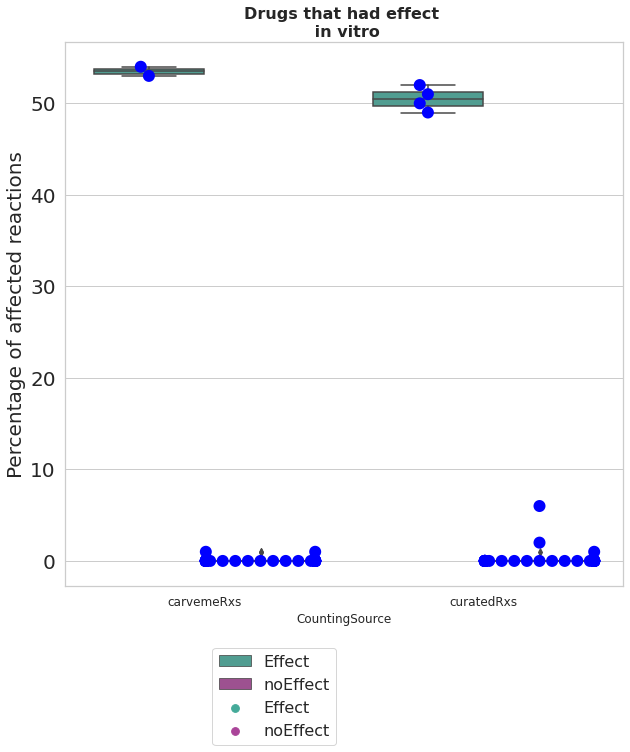

In [7]:
# plt.figure(figsize = (10,10))
plt.figure(figsize = (10,10))
carvemeDF=dfs.copy()
sns.set_theme(style="whitegrid")

g=sns.boxplot(y='Affected reactions', x='CountingSource', hue='EffectOnGrowth', data=carvemeDF,order=['carvemeRxs', 'curatedRxs'],hue_order=['Effect', 'noEffect'], palette=dict(Effect = '#44aa99', noEffect = '#aa4499'))

# , order=['StitchInhibtProteins', 'modelInhibtProteins','CURATEDInhibtProteins']

g=sns.swarmplot(y='Affected reactions', x='CountingSource', hue='EffectOnGrowth', data=carvemeDF, order=['carvemeRxs', 'curatedRxs'], hue_order=['Effect', 'noEffect'], color='black', palette=dict(Effect = '#44aa99', noEffect = '#aa4499'), linewidth=6,edgecolor='blue',  size=6, dodge=True)
# g=sns.stripplot(y='InhibitedProteins', x='CountingSource', hue='EffectOnGrowth', data=carvemeDF, color='black', linewidth=4,edgecolor='red',  size=5, dodge=True)

plt.title("Drugs that had effect \n in vitro",fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=20)
# plt.xlabel(['STITCH', 'Carveme', 'Curated'],fontsize=16)
plt.ylabel('Percentage of affected reactions',fontsize=20)
horiz_offset = 0.5
vert_offset = -0.1
plt.legend(bbox_to_anchor=(horiz_offset, vert_offset),fontsize=16)
# g=sns.set(rc={'figure.figsize':(50,50)})
# plt.savefig("carveme_boxplot_Drugs.png")
# plt.savefig('allOtherDrugs_proteinsBoxplot.pdf', format="pdf",bbox_inches="tight")
# plt.savefig('allOtherDrugs_reactionsBoxplot.png',bbox_inches="tight")

All and LB models have the same boxplots because the drugs that inhibit growth in both are the same 